# Sistema de Recomendación de Destinos para Usuarios

## Unión De Información Disponible

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Utilidades
import os
import warnings
warnings.filterwarnings("ignore")

# Utilidad para exportar el modelo
import joblib

# Utilidad para GridSearch
import itertools

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/travel-recommendation-dataset/Final_Updated_Expanded_Users.csv
/kaggle/input/travel-recommendation-dataset/Expanded_Destinations.csv
/kaggle/input/travel-recommendation-dataset/Final_Updated_Expanded_Reviews.csv
/kaggle/input/travel-recommendation-dataset/Final_Updated_Expanded_UserHistory.csv


No consideramos el review id ya que

In [3]:
# Rutas
path = "/kaggle/input/travel-recommendation-dataset/"

# Carga
df_users = pd.read_csv(path + "Final_Updated_Expanded_Users.csv")
df_dest = pd.read_csv(path + "Expanded_Destinations.csv")
df_history = pd.read_csv(path + "Final_Updated_Expanded_UserHistory.csv")

In [4]:
df_users.shape

(999, 7)

In [5]:
df_dest.shape

(1000, 6)

In [6]:
df_history.shape

(999, 5)

In [7]:
# Merge 1: history + users (por UserID)
df_model = df_history.merge(df_users, on="UserID", how="left")

# Merge 2: resultado anterior + destinations (por DestinationID)
df_model = df_model.merge(df_dest, on="DestinationID", how="left")

In [8]:
df_model = df_model.rename(columns={
    "Name_x": "NameUser",
    "Name_y": "NameDestination"
})

In [9]:
df_model.head(10)

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating,NameUser,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren,NameDestination,State,Type,Popularity,BestTimeToVisit
0,1,525,760,2024-01-01,3,Saanvi,saanvi@example.com,"City, Historical",Female,2,2,Leh Ladakh,Jammu and Kashmir,Adventure,8.352180,Apr-Jun
1,2,184,532,2024-02-15,5,Ishaan,ishaan@example.com,"Beaches, Historical",Male,1,2,Goa Beaches,Goa,Beach,8.988127,Nov-Mar
2,3,897,786,2024-03-20,2,Pooja,pooja@example.com,"City, Historical",Female,1,2,Taj Mahal,Uttar Pradesh,Historical,8.389206,Nov-Feb
3,4,470,660,2024-01-01,1,Arjun,arjun@example.com,"Nature, Adventure",Male,2,1,Leh Ladakh,Jammu and Kashmir,Adventure,7.923388,Apr-Jun
4,5,989,389,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,2,1,Kerala Backwaters,Kerala,Nature,9.409146,Sep-Mar
5,6,266,394,2024-03-20,3,Vivaan,vivaan@example.com,"Nature, Adventure",Male,2,1,Kerala Backwaters,Kerala,Nature,8.884526,Sep-Mar
6,7,399,953,2024-01-01,2,Dhruv,dhruv@example.com,"City, Historical",Male,1,1,Jaipur City,Rajasthan,City,8.321399,Oct-Mar
7,8,869,901,2024-02-15,4,Karan,karan@example.com,"Nature, Adventure",Male,1,1,Taj Mahal,Uttar Pradesh,Historical,7.943844,Nov-Feb
8,9,580,890,2024-03-20,1,Riya,riya@example.com,"Beaches, Historical",Female,1,0,Leh Ladakh,Jammu and Kashmir,Adventure,7.743040,Apr-Jun
9,10,876,727,2024-01-01,4,Ritvik,ritvik@example.com,"City, Historical",Male,2,2,Goa Beaches,Goa,Beach,7.714387,Nov-Mar


In [10]:
# Obtener nombres únicos ordenados
unique_names = sorted(df_model['NameDestination'].unique())

# Crear nuevo mapper: nombre → ID entero consecutivo
name_to_new_id = {name: idx for idx, name in enumerate(unique_names)}

In [11]:
# Asignar nuevos IDs
df_model['DestinationID'] = df_model['NameDestination'].map(name_to_new_id)

In [12]:
df_model.head()

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating,NameUser,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren,NameDestination,State,Type,Popularity,BestTimeToVisit
0,1,525,3,2024-01-01,3,Saanvi,saanvi@example.com,"City, Historical",Female,2,2,Leh Ladakh,Jammu and Kashmir,Adventure,8.352180,Apr-Jun
1,2,184,0,2024-02-15,5,Ishaan,ishaan@example.com,"Beaches, Historical",Male,1,2,Goa Beaches,Goa,Beach,8.988127,Nov-Mar
2,3,897,4,2024-03-20,2,Pooja,pooja@example.com,"City, Historical",Female,1,2,Taj Mahal,Uttar Pradesh,Historical,8.389206,Nov-Feb
3,4,470,3,2024-01-01,1,Arjun,arjun@example.com,"Nature, Adventure",Male,2,1,Leh Ladakh,Jammu and Kashmir,Adventure,7.923388,Apr-Jun
4,5,989,2,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,2,1,Kerala Backwaters,Kerala,Nature,9.409146,Sep-Mar


In [13]:
destination_name_mapper = {v: k for k, v in name_to_new_id.items()}

In [14]:
joblib.dump(destination_name_mapper, "destination_name_mapper.pkl")

['destination_name_mapper.pkl']

In [15]:
# --- Crear copia de trabajo ---
df_multi_hot = df_model.copy()

# --- Paso 1: Multi-hot encoding de Preferences ---
df_multi_hot['Preferences'] = df_multi_hot['Preferences'].apply(
    lambda x: [p.strip() for p in x.split(',')] if isinstance(x, str) else x
)

mlb = MultiLabelBinarizer()
prefs_encoded = pd.DataFrame(
    mlb.fit_transform(df_multi_hot['Preferences']),
    columns=mlb.classes_,
    index=df_multi_hot.index
)

# Concatenar multi-hot y eliminar Preferences
df_multi_hot = pd.concat([df_multi_hot.drop(columns='Preferences'), prefs_encoded], axis=1)

# Guardar el codificador para uso futuro
joblib.dump(mlb, "mlb_preferences.pkl")

# --- Paso 2: Dropear columnas irrelevantes ---
cols_to_drop = ["HistoryID", "NameUser", "Email", "NameDestination", "BestTimeToVisit", "State"]
df_multi_hot = df_multi_hot.drop(columns=[col for col in cols_to_drop if col in df_multi_hot.columns])

In [16]:
df_multi_hot.head()

,UserID,DestinationID,VisitDate,ExperienceRating,Gender,NumberOfAdults,NumberOfChildren,Type,Popularity,Adventure,Beaches,City,Historical,Nature
0,525,3,2024-01-01,3,Female,2,2,Adventure,8.352180,0,0,1,1,0
1,184,0,2024-02-15,5,Male,1,2,Beach,8.988127,0,1,0,1,0
2,897,4,2024-03-20,2,Female,1,2,Historical,8.389206,0,0,1,1,0
3,470,3,2024-01-01,1,Male,2,1,Adventure,7.923388,1,0,0,0,1
4,989,2,2024-02-15,4,Male,2,1,Nature,9.409146,1,0,0,0,1


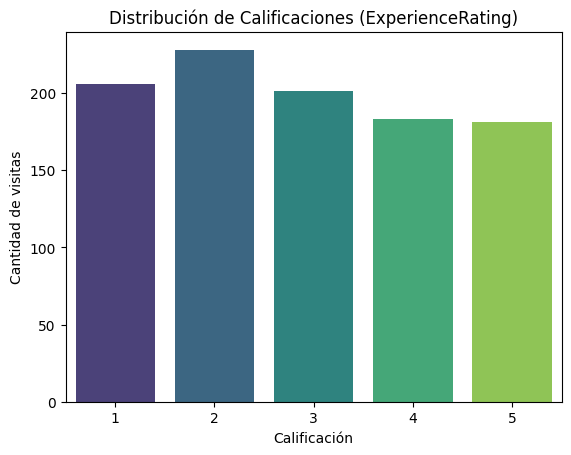

In [17]:
sns.countplot(x="ExperienceRating", data=df_multi_hot, palette="viridis")
plt.title("Distribución de Calificaciones (ExperienceRating)")
plt.xlabel("Calificación")
plt.ylabel("Cantidad de visitas")
plt.show()

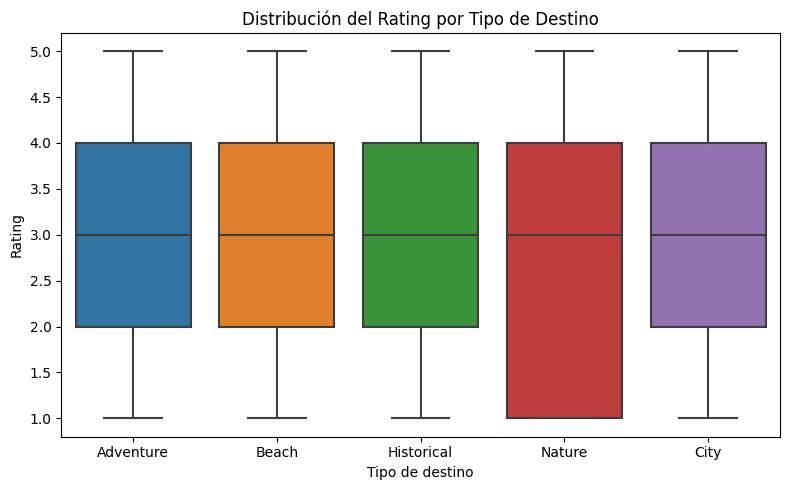

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Type", y="ExperienceRating", data=df_multi_hot)
plt.title("Distribución del Rating por Tipo de Destino")
plt.xlabel("Tipo de destino")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

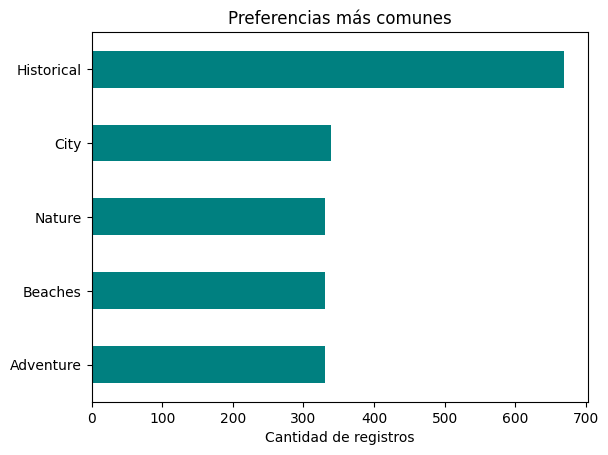

In [19]:
prefs = ['Adventure', 'Beaches', 'City', 'Historical', 'Nature']
df_multi_hot[prefs].sum().sort_values().plot(kind="barh", color="teal")
plt.title("Preferencias más comunes")
plt.xlabel("Cantidad de registros")
plt.show()

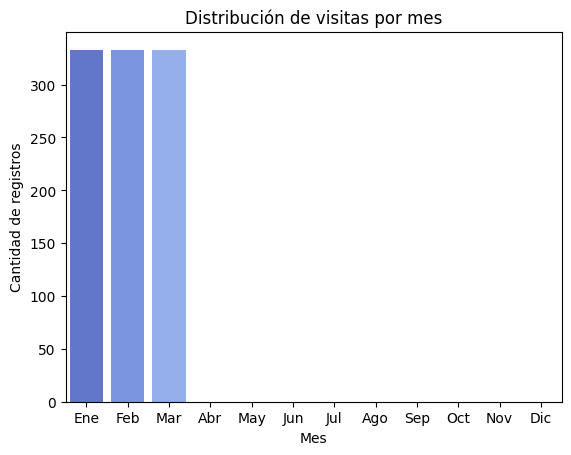

In [20]:
# Asegurar tipo datetime
df_multi_hot['VisitDate'] = pd.to_datetime(df_multi_hot['VisitDate'], errors='coerce')
df_multi_hot['VisitMonth'] = df_multi_hot['VisitDate'].dt.month

# Contar por mes con todos los meses del 1 al 12
month_counts = df_multi_hot['VisitMonth'].value_counts().reindex(range(1, 13), fill_value=0).sort_index()

# Plot
sns.barplot(x=month_counts.index, y=month_counts.values, palette="coolwarm")
plt.title("Distribución de visitas por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de registros")
plt.xticks(ticks=range(0, 12), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", 
                                       "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.show()

In [21]:
# Crear copia de trabajo
df_cyclic = df_multi_hot.copy()

# Asegurar formato datetime
df_cyclic['VisitDate'] = pd.to_datetime(df_cyclic['VisitDate'], errors='coerce')

# Extraer mes y calcular codificación cíclica
df_cyclic['VisitMonth'] = df_cyclic['VisitDate'].dt.month
df_cyclic['Month_sin'] = np.sin(2 * np.pi * df_cyclic['VisitMonth'] / 12)
df_cyclic['Month_cos'] = np.cos(2 * np.pi * df_cyclic['VisitMonth'] / 12)

# Eliminar columnas originales de fecha
df_cyclic = df_cyclic.drop(columns=['VisitDate', 'VisitMonth'])

In [22]:
df_cyclic.head()

,UserID,DestinationID,ExperienceRating,Gender,NumberOfAdults,NumberOfChildren,Type,Popularity,Adventure,Beaches,City,Historical,Nature,Month_sin,Month_cos
0,525,3,3,Female,2,2,Adventure,8.352180,0,0,1,1,0,0.500000,8.660254e-01
1,184,0,5,Male,1,2,Beach,8.988127,0,1,0,1,0,0.866025,5.000000e-01
2,897,4,2,Female,1,2,Historical,8.389206,0,0,1,1,0,1.000000,6.123234e-17
3,470,3,1,Male,2,1,Adventure,7.923388,1,0,0,0,1,0.500000,8.660254e-01
4,989,2,4,Male,2,1,Nature,9.409146,1,0,0,0,1,0.866025,5.000000e-01


In [23]:
# --- Crear copia de trabajo ---
df_onehot = df_cyclic.copy()

# --- Definir columnas a one-hot ---
one_hot_cols = ['Gender', 'Type']

# --- Aplicar OneHotEncoder ---
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_onehot[one_hot_cols])

# Crear DataFrame de columnas codificadas
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(one_hot_cols),
    index=df_onehot.index
)

# --- Reemplazar solo las columnas originales ---
df_onehot = pd.concat([df_onehot.drop(columns=one_hot_cols), encoded_df], axis=1)

# --- Guardar el encoder para producción ---
joblib.dump(encoder, "onehot_encoder.pkl")

['onehot_encoder.pkl']

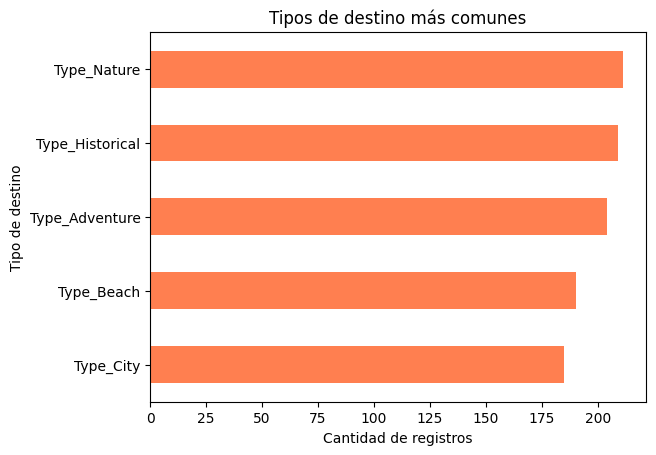

In [24]:
type_cols = [col for col in df_onehot.columns if col.startswith("Type_")]

df_onehot[type_cols].sum().sort_values().plot(
    kind="barh", 
    color="coral"
)
plt.title("Tipos de destino más comunes")
plt.xlabel("Cantidad de registros")
plt.ylabel("Tipo de destino")
plt.show()

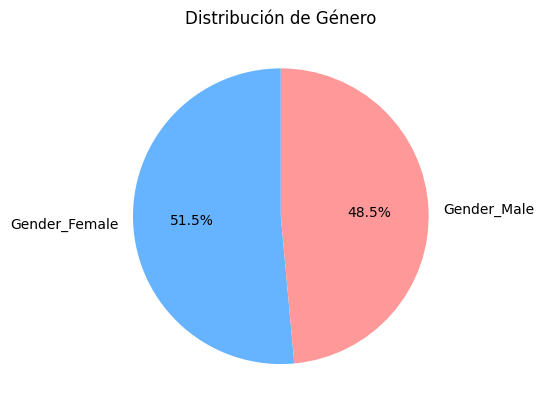

In [25]:
gender_cols = [col for col in df_onehot.columns if col.startswith("Gender_")]

df_onehot[gender_cols].sum().plot(
    kind="pie", 
    autopct='%1.1f%%', 
    startangle=90, 
    labels=gender_cols,
    colors=["#66b3ff", "#ff9999"]
)
plt.title("Distribución de Género")
plt.ylabel("")
plt.show()

In [26]:
# --- Crear copia final de trabajo ---
df_final = df_onehot.copy()

# --- Definir columnas a normalizar ---
numeric_cols = ['NumberOfAdults', 'NumberOfChildren', 'Popularity', 'Month_sin', 'Month_cos']

# --- Aplicar MinMaxScaler solo a esas columnas ---
scaler = MinMaxScaler()
df_final[numeric_cols] = scaler.fit_transform(df_final[numeric_cols])

# --- Guardar scaler para usar en producción ---
joblib.dump(scaler, "scaler_recomendacion.pkl")

['scaler_recomendacion.pkl']

In [27]:
df_final.head()

,UserID,DestinationID,ExperienceRating,NumberOfAdults,NumberOfChildren,Popularity,Adventure,Beaches,City,Historical,Nature,Month_sin,Month_cos,Gender_Female,Gender_Male,Type_Adventure,Type_Beach,Type_City,Type_Historical,Type_Nature
0,525,3,3,1.0,1.0,0.424836,0,0,1,1,0,0.000000,1.00000,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,184,0,5,0.0,1.0,0.743557,0,1,0,1,0,0.732051,0.57735,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,897,4,2,0.0,1.0,0.443392,0,0,1,1,0,1.000000,0.00000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,470,3,1,1.0,0.5,0.209936,1,0,0,0,1,0.000000,1.00000,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,989,2,4,1.0,0.5,0.954561,1,0,0,0,1,0.732051,0.57735,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [28]:
df_final.columns

Index(['UserID', 'DestinationID', 'ExperienceRating', 'NumberOfAdults',
       'NumberOfChildren', 'Popularity', 'Adventure', 'Beaches', 'City',
       'Historical', 'Nature', 'Month_sin', 'Month_cos', 'Gender_Female',
       'Gender_Male', 'Type_Adventure', 'Type_Beach', 'Type_City',
       'Type_Historical', 'Type_Nature'],
      dtype='object')

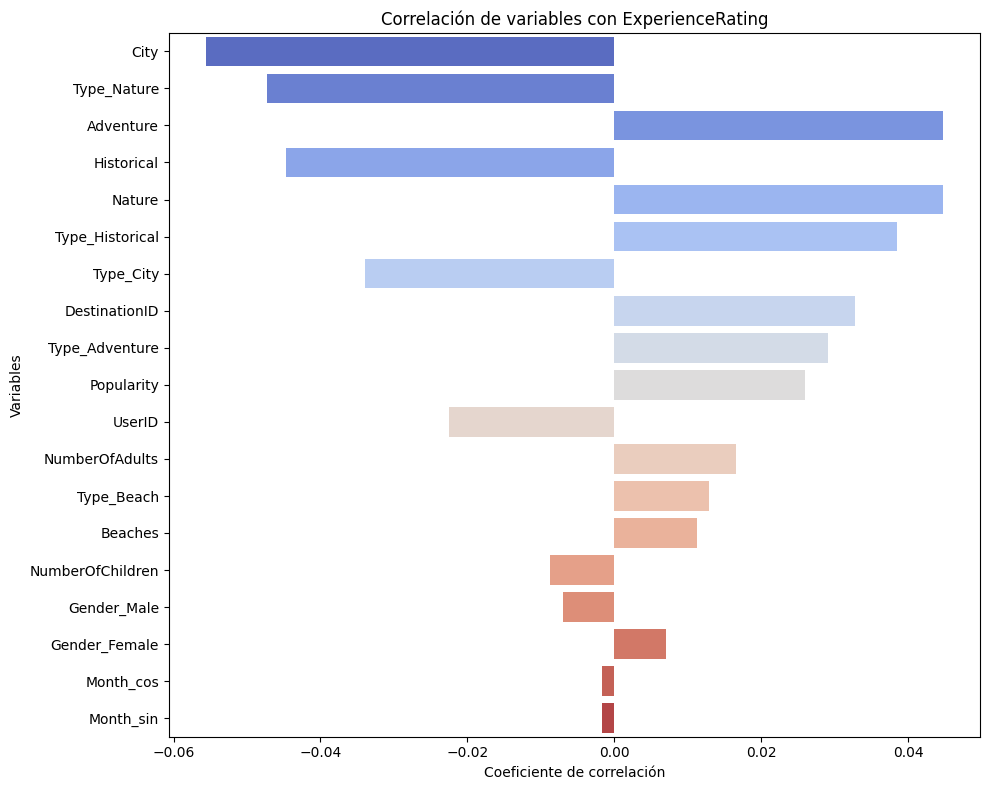

In [29]:
# Calcular correlaciones con la variable objetivo
correlation_with_target = df_final.corr()["ExperienceRating"].drop("ExperienceRating")

# Ordenar de mayor a menor (absoluto)
correlation_sorted = correlation_with_target.reindex(
    correlation_with_target.abs().sort_values(ascending=False).index
)

# Graficar
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_sorted.values, y=correlation_sorted.index, palette="coolwarm")
plt.title("Correlación de variables con ExperienceRating")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

In [30]:
# Calcular matriz de correlación
corr = df_final.corr().copy()

# Eliminar la columna y fila de ExperienceRating
corr = corr.drop("ExperienceRating", axis=0).drop("ExperienceRating", axis=1)

# Convertir a un DataFrame plano con pares de variables
corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_flat = corr_pairs.stack().reset_index()
corr_flat.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Ordenar por la magnitud de la correlación (valor absoluto)
corr_flat['AbsCorr'] = corr_flat['Correlación'].abs()
top_corrs = corr_flat.sort_values(by='AbsCorr', ascending=False).drop(columns="AbsCorr").head(25)

# Mostrar
print("🔗 Top 25 correlaciones cruzadas entre variables:\n")
print(top_corrs.to_string(index=False))

🔗 Top 25 correlaciones cruzadas entre variables:

     Variable 1      Variable 2  Correlación
      Adventure      Historical    -1.000000
      Adventure          Nature     1.000000
     Historical          Nature    -1.000000
  Gender_Female     Gender_Male    -1.000000
      Month_sin       Month_cos    -0.939071
  DestinationID Type_Historical     0.709542
  DestinationID      Type_Beach    -0.707795
      Adventure            City    -0.503352
           City          Nature    -0.503352
           City      Historical     0.503352
        Beaches            City    -0.503352
        Beaches          Nature    -0.493274
      Adventure         Beaches    -0.493274
        Beaches      Historical     0.493274
  DestinationID       Type_City    -0.357792
  DestinationID  Type_Adventure     0.339137
Type_Historical     Type_Nature    -0.266157
 Type_Adventure     Type_Nature    -0.262126
 Type_Adventure Type_Historical    -0.260550
     Type_Beach     Type_Nature    -0.250773
     

In [31]:
joblib.dump(df_final.columns.tolist(), "column_order.pkl")

['column_order.pkl']

In [32]:
# --- 1. Ver estructura general ---
print("🔍 Dimensiones del DataFrame:", df_final.shape)
print("🧱 Columnas:", df_final.columns.tolist())

# --- 2. Verifica valores nulos ---
print("\n❓ Valores nulos por columna:")
print(df_final.isnull().sum())

# --- 3. Verifica tipos de datos ---
print("\n🔠 Tipos de datos:")
print(df_final.dtypes)

# --- 4. Verifica rango de columnas normalizadas ---
numeric_cols = ['NumberOfAdults', 'NumberOfChildren', 'Popularity', 'Month_sin', 'Month_cos']
print("\n📈 Rango de columnas numéricas normalizadas:")
print(df_final[numeric_cols].describe().loc[['min', 'max']])

# --- 5. Verifica consistencia en columnas one-hot ---
onehot_prefixes = ['Gender_', 'Type_']
print("\n✅ Verificando consistencia de columnas one-hot:")
for prefix in onehot_prefixes:
    cols = [col for col in df_final.columns if col.startswith(prefix)]
    sums = df_final[cols].sum(axis=1)
    if not ((sums == 1).all()):
        print(f"⚠️ Inconsistencia en columnas con prefijo '{prefix}' (valores ≠ 1 por fila)")
    else:
        print(f"✔️ OK: columnas '{prefix}' suman 1 por fila")

# --- 6. Verifica valores en target si ya está incluido ---
if 'ExperienceRating' in df_final.columns:
    print("\n🎯 Distribución de etiquetas (ExperienceRating):")
    print(df_final['ExperienceRating'].value_counts().sort_index())

🔍 Dimensiones del DataFrame: (999, 20)
🧱 Columnas: ['UserID', 'DestinationID', 'ExperienceRating', 'NumberOfAdults', 'NumberOfChildren', 'Popularity', 'Adventure', 'Beaches', 'City', 'Historical', 'Nature', 'Month_sin', 'Month_cos', 'Gender_Female', 'Gender_Male', 'Type_Adventure', 'Type_Beach', 'Type_City', 'Type_Historical', 'Type_Nature']

❓ Valores nulos por columna:
UserID              0
DestinationID       0
ExperienceRating    0
NumberOfAdults      0
NumberOfChildren    0
Popularity          0
Adventure           0
Beaches             0
City                0
Historical          0
Nature              0
Month_sin           0
Month_cos           0
Gender_Female       0
Gender_Male         0
Type_Adventure      0
Type_Beach          0
Type_City           0
Type_Historical     0
Type_Nature         0
dtype: int64

🔠 Tipos de datos:
UserID                int64
DestinationID         int64
ExperienceRating      int64
NumberOfAdults      float64
NumberOfChildren    float64
Popularity    

## Ejemplo de uso en producción

In [33]:
def transform_row_for_model(row, mlb, encoder, scaler, column_order):
    import pandas as pd
    import numpy as np

    row = row.copy()
    row = pd.DataFrame([row]) if isinstance(row, pd.Series) else row

    # --- Preferences a multi-hot ---
    row['Preferences'] = row['Preferences'].apply(lambda x: [p.strip() for p in x.split(',')] if isinstance(x, str) else x)
    prefs = pd.DataFrame(mlb.transform(row['Preferences']), columns=mlb.classes_, index=row.index)

    # --- Codificación cíclica de fecha ---
    row['VisitDate'] = pd.to_datetime(row['VisitDate'], errors='coerce')
    row['VisitMonth'] = row['VisitDate'].dt.month
    row['Month_sin'] = np.sin(2 * np.pi * row['VisitMonth'] / 12)
    row['Month_cos'] = np.cos(2 * np.pi * row['VisitMonth'] / 12)

    # --- Normalización ---
    numeric_cols = ['NumberOfAdults', 'NumberOfChildren', 'Popularity', 'Month_sin', 'Month_cos']
    row[numeric_cols] = scaler.transform(row[numeric_cols])

    # --- One-hot ---
    one_hot_cols = ['Gender', 'Type']
    onehot = encoder.transform(row[one_hot_cols])
    onehot_df = pd.DataFrame(onehot, columns=encoder.get_feature_names_out(one_hot_cols), index=row.index)

    # --- Concatenar ---
    base_cols = ['UserID', 'DestinationID', 'ExperienceRating'] + numeric_cols
    transformed = pd.concat([row[base_cols], prefs, onehot_df], axis=1)

    # --- Ordenar columnas según entrenamiento ---
    transformed = transformed[column_order]

    return transformed

In [34]:
mlb = joblib.load("/kaggle/working/mlb_preferences.pkl")
encoder = joblib.load("/kaggle/working/onehot_encoder.pkl")
scaler = joblib.load("/kaggle/working/scaler_recomendacion.pkl")
column_order = joblib.load("/kaggle/working/column_order.pkl")

In [35]:
row = df_model.iloc[0]
row_ready = transform_row_for_model(row, mlb, encoder, scaler, column_order)

In [36]:
def compare_transformed_vs_original(transformed_row, df_final, idx):
    """
    Compara una fila transformada con la correspondiente en df_final.

    Args:
        transformed_row: resultado de transform_row_for_model
        df_final: DataFrame completo ya procesado
        idx: índice de la fila original en df_model / df_final

    Returns:
        True si coincide completamente (valor y orden), False si no.
    """
    original_row = df_final.iloc[[idx]]
    same_shape = transformed_row.shape == original_row.shape
    same_columns = transformed_row.columns.equals(original_row.columns)
    same_values = np.allclose(transformed_row.values, original_row.values, atol=1e-6)

    print(f"✔️ Mismo shape: {same_shape}")
    print(f"✔️ Mismo orden de columnas: {same_columns}")
    print(f"✔️ Valores equivalentes: {same_values}")
    
    return same_shape and same_columns and same_values

In [37]:
# Transformar la fila
row = df_model.iloc[0]
row_ready = transform_row_for_model(row, mlb, encoder, scaler, column_order)

# Comparar con df_final
compare_transformed_vs_original(row_ready, df_final, idx=row.name)

✔️ Mismo shape: True
✔️ Mismo orden de columnas: True
✔️ Valores equivalentes: True


True

In [38]:
df_final.to_csv("df_ready_for_training.csv", index=False)